# Part I. ETL Pipeline for Pre-Processing the Files

#### Import Python packages 

In [67]:
# Import Python packages 
import pandas as pd
import cassandra
from cassandra.query import BatchStatement
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [68]:
# checking your current working directory
print(os.getcwd())

# Get your current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    #print(file_path_list)

/Users/melzarei/udacity-dend/1_Data_Modeling/2_NoSQL


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [69]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:

# reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
 # extracting each data row one by one and append it        
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line) 
            
# uncomment the code below if you would like to get total number of rows 
#print(len(full_data_rows_list))
# uncomment the code below if you would like to check to see what the list of event data rows will look like
#print(full_data_rows_list)

# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


In [70]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


## Queries to answer

1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4

2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182

3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'


## Data Exploration
We explore the data to get a sense of how it's distributed.

In [71]:
csv_data = pd.read_csv('event_datafile_new.csv')
csv_data.head()

,artist,firstName,gender,itemInSession,lastName,length,level,location,sessionId,song,userId
0,Harmonia,Ryan,M,0,Smith,655.77751,free,"San Jose-Sunnyvale-Santa Clara, CA",583,Sehr kosmisch,26
1,The Prodigy,Ryan,M,1,Smith,260.07465,free,"San Jose-Sunnyvale-Santa Clara, CA",583,The Big Gundown,26
2,Train,Ryan,M,2,Smith,205.45261,free,"San Jose-Sunnyvale-Santa Clara, CA",583,Marry Me,26
3,Sony Wonder,Samuel,M,0,Gonzalez,218.06975,free,"Houston-The Woodlands-Sugar Land, TX",597,Blackbird,61
4,Van Halen,Tegan,F,2,Levine,289.38404,paid,"Portland-South Portland, ME",602,Best Of Both Worlds (Remastered Album Version),80


Data in `session_id` seem to be normally distributed so it's a good candidate for a partition key.

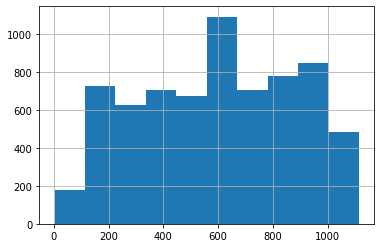

In [72]:
session_ids = csv_data['sessionId'].hist().plot()

`item_in_session` is bad and not evenly distributed as expected, most users play small number of songs per session.

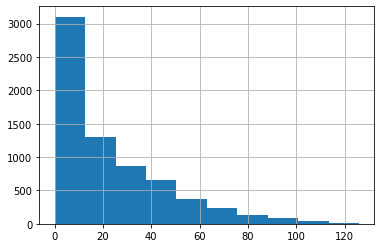

In [73]:
item_in_session =  csv_data['itemInSession'].hist().plot()

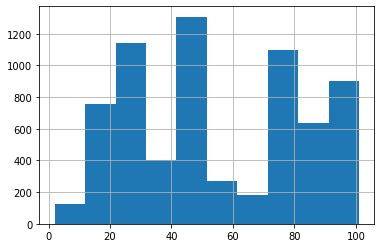

In [74]:
user_ids =  csv_data['userId'].hist().plot()

In [75]:
first_query_result = csv_data[ (csv_data['sessionId'] == 338) & (csv_data['itemInSession'] == 4)]
first_query_result[['song', 'artist', 'length']]

,song,artist,length
6360,Music Matters (Mark Knight Dub),Faithless,495.3073


In [76]:
second_query_result = csv_data[ (csv_data['sessionId'] == 182) & (csv_data['userId'] == 10)]
second_query_result[['artist', 'song', 'firstName', 'lastName']]

,artist,song,firstName,lastName
4573,Down To The Bone,Keep On Keepin' On,Sylvie,Cruz
4574,Three Drives,Greece 2000,Sylvie,Cruz
4575,Sebastien Tellier,Kilometer,Sylvie,Cruz
4576,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Sylvie,Cruz


In [77]:
third_query_result = csv_data[ (csv_data['song'] == 'All Hands Against His Own')]
third_query_result[['firstName', 'lastName']]

,firstName,lastName
84,Tegan,Levine
2105,Sara,Johnson
3281,Jacqueline,Lynch


## Apache Cassandra code

#### Creating a Cluster

In [94]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)

from cassandra.cluster import Cluster
cluster = Cluster()


# To establish connection and begin executing queries, need a session
session = cluster.connect()

def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

# Fetch results as pandas dataframe
session.row_factory = pandas_factory
session.default_fetch_size = None

#### Create Keyspace

In [95]:
KEYSPACE_NAME = "sparkifydb"
create_keyspace_query = f"""
CREATE KEYSPACE IF NOT EXISTS {KEYSPACE_NAME}
WITH REPLICATION = {{ 'class' : 'SimpleStrategy', 'replication_factor' : 1 }}
"""
session.execute(create_keyspace_query)

#### Set Keyspace

In [96]:
session.set_keyspace(KEYSPACE_NAME)

### Create Tables & Insert Data

In [97]:
def insert_cassandra_data(query, cols, data=csv_data, chunk_size=500):
    """
    Helper function to batch insert data into cassandra.
    """
    data_to_insert = data[cols].values
    
    # chunk the batch into chunk_size chunks
    data_chunked = np.array_split(data_to_insert, data_to_insert.shape[0] // chunk_size)
    
    # for each data chunk batch insert into cassandra
    for chunk in data_chunked:
        batch = BatchStatement(consistency_level=cassandra.ConsistencyLevel.QUORUM)
        for row in chunk:
            batch.add(query, tuple(row))
        session.execute(batch)

###  Query 1:


Give me the artist, song title and song's length in the music app history that was heard during `sessionId = 338, and itemInSession = 4`

#### Query Description
In this query, I used `session_id` as the partition key and `item_in_session` as my clustering key.

In [98]:
song_history_table = """
CREATE TABLE IF NOT EXISTS song_history(
    session_id int,
    item_in_session int,
    artist_name text,
    song text,
    length double,
    PRIMARY KEY (session_id, item_in_session)
)
"""
session.execute(song_history_table)

In [99]:
insert_cols = ['sessionId', 'itemInSession', 'artist', 'song', 'length']
query = """
    INSERT INTO song_history (session_id, item_in_session, artist_name, song, length) values (%s, %s, %s, %s, %s) 
"""
insert_cassandra_data(query, insert_cols)

### Query 2: 

Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182

#### Query Description
In this query, I used both (`session_id`, `user_id`) as the partition key and `item_in_session` as my clustering key.

In [100]:
song_history_user_info_table = """
CREATE TABLE IF NOT EXISTS song_history_user_info(
    session_id int,
    user_id int,
    item_in_session int,
    artist_name text,
    song text,
    first_name text,
    last_name text,
    PRIMARY KEY ((session_id, user_id), item_in_session)
)
"""
session.execute(song_history_user_info_table)

In [102]:
insert_cols = ['sessionId', 'userId', 'itemInSession', 'artist', 'song', 'firstName', 'lastName']
query = """
    INSERT INTO song_history_user_info (session_id, user_id, item_in_session, artist_name, song, first_name, last_name)
    values (%s, %s, %s, %s, %s, %s, %s) 
"""
insert_cassandra_data(query, insert_cols, chunk_size=250)

### Query 3:

Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

#### Query Description
In this query, I used (`song`) as the partition key and `user_id` as my clustering key. The combination of them forms a unique `primarykey`.

In [108]:
song_users_table = """
CREATE TABLE IF NOT EXISTS song_users_table(
    song text,
    user_id int,
    first_name text,
    last_name text,
    PRIMARY KEY (song, user_id)
)
"""
session.execute(song_users_table)

In [109]:
insert_cols = ['song', 'userId', 'firstName', 'lastName']
query = """
    INSERT INTO song_users_table (song, user_id, first_name, last_name) values (%s, %s, %s, %s) 
"""
insert_cassandra_data(query, insert_cols)

### Select Queries

In [110]:
select_one = """
SELECT artist_name, song, length from song_history WHERE session_id = 338 AND item_in_session = 4
"""
results = session.execute(select_one)
results._current_rows

,artist_name,song,length
0,Faithless,Music Matters (Mark Knight Dub),495.3073


In [111]:
select_two = """
SELECT artist_name, song, first_name, last_name FROM song_history_user_info WHERE session_id = 182 AND user_id = 10
"""
results = session.execute(select_two)
results._current_rows

,artist_name,song,first_name,last_name
0,Down To The Bone,Keep On Keepin' On,Sylvie,Cruz
1,Three Drives,Greece 2000,Sylvie,Cruz
2,Sebastien Tellier,Kilometer,Sylvie,Cruz
3,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Sylvie,Cruz


In [112]:
select_three = """
SELECT first_name, last_name FROM song_users_table WHERE song = 'All Hands Against His Own'
"""
results = session.execute(select_three)
results._current_rows

,first_name,last_name
0,Jacqueline,Lynch
1,Tegan,Levine
2,Sara,Johnson


### Drop the tables before closing out the sessions

In [113]:
tables = ['song_history', 'song_history_user_info', 'song_users_table']
for table in tables:
    session.execute(f'DROP TABLE IF EXISTS {table}')

### Close the session and cluster connection¶

In [114]:
session.shutdown()
cluster.shutdown()